In [11]:
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt
dir_name = 'heterogeneity_results'
file_name_ddn = '2024-09-26_single_task_exp_DDN_fixed_decay_per_cluster.p'
file_name_esn = '2024-09-26_single_task_exp_BL_fixed_decay_per_cluster.p'

esn_dict = pkl.load(open(dir_name + '/' + file_name_esn, 'rb'))
ddn_dict = pkl.load(open(dir_name + '/' + file_name_ddn, 'rb'))

In [8]:
esn_example = esn_dict['example net']
ddn_example = ddn_dict['example net']

In [10]:
def get_validation_throughout_evolution(dict, gen_max, populations=False, multitask=False):
    # Validation scores are saved in a matrix with dimensions:
    # generations x hyperparameter candidates x re-initializations x lag search grid
    if not multitask:
        all_scores = dict['validation performance'][:gen_max, :, :, :]
    else:
        all_scores = dict['validation performance'][:gen_max, :, :, :, :]
    # from the lag search grid we select the best score (lowest NRMSE), since this was the best 
    # performing readout model
    best_lag_scores = np.min(all_scores, axis=-1)
    
    if multitask:
        # from the tasks, we select the average
        # best_lag_scores = best_lag_scores[:, :, :, 0]**2
        best_lag_scores = np.mean(best_lag_scores, axis=-1)
    
    # from the re-initializations from the same hyperparameter set/candidate, we take the average
    best_candidate_scores = np.mean(best_lag_scores, axis=-1)
    
    if populations:
        return best_candidate_scores
    
    # from the population of hyperparameter candidates, we select the best candidate
    best_gen_scores = np.min(best_candidate_scores, axis=-1)
    return best_gen_scores

def get_best_candidate(dict, gen_max, multitask=False):
    best_gen_scores = get_validation_throughout_evolution(dict, gen_max, multitask=multitask)   
    best_candidates = get_validation_throughout_evolution(dict, gen_max, populations=True, multitask=multitask)
    best_gen_ind = np.argmin(best_gen_scores)
    best_candidate_ind = np.argmin(best_candidates[best_gen_ind])
    return best_gen_ind, best_candidate_ind
    
def sample_best_net(dict, n, gen_max, multitask=False):
    gen, ind = get_best_candidate(dict, gen_max, multitask=multitask)
    print(gen, ind)
    start_net = dict['example net']
    best_parameter_set = dict['parameters'][gen, ind, :]
    best_nets = []
    for i in range(n):
        best_net = start_net.get_new_network_from_serialized(best_parameter_set)
        best_nets.append(best_net)
    return best_nets


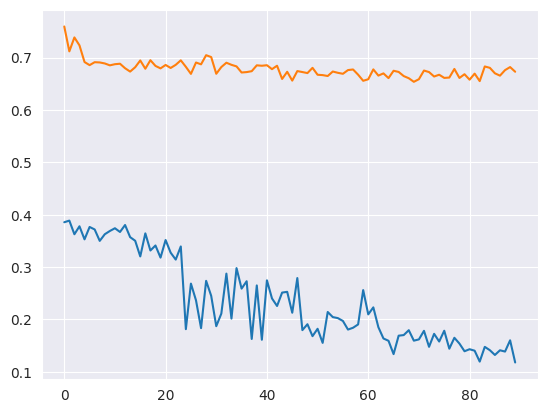

In [14]:
gen_max = 90
val_scores_ddn = get_validation_throughout_evolution(ddn_dict, gen_max, multitask=False)
val_scores_esn = get_validation_throughout_evolution(esn_dict, gen_max, multitask=False)
plt.plot(val_scores_ddn)
plt.plot(val_scores_esn)

In [15]:
nr_of_nets = 10
best_nets_ddns = sample_best_net(ddn_dict, nr_of_nets, gen_max, multitask=False)
best_nets_esns = sample_best_net(esn_dict, nr_of_nets, gen_max, multitask=False)

89 13
69 14


In [16]:
print(best_nets_ddns)

[<populations.FlexiblePopulation object at 0x7f4db64b6e20>, <populations.FlexiblePopulation object at 0x7f4db6437490>, <populations.FlexiblePopulation object at 0x7f4db64ace20>, <populations.FlexiblePopulation object at 0x7f4db63fd160>, <populations.FlexiblePopulation object at 0x7f4db64cea90>, <populations.FlexiblePopulation object at 0x7f4db64ace50>, <populations.FlexiblePopulation object at 0x7f4db64ac670>, <populations.FlexiblePopulation object at 0x7f4db6d95b20>, <populations.FlexiblePopulation object at 0x7f4db6e7dc40>, <populations.FlexiblePopulation object at 0x7f4db64acd90>]


# Visualize Networks

RuntimeError: Too early to create image: no default root window

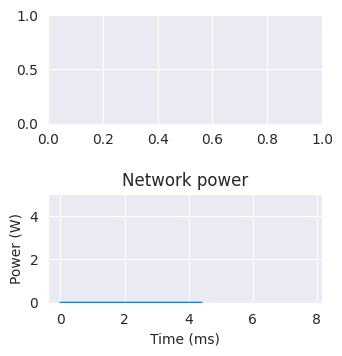

In [17]:
from simulator import NetworkSimulator
sim = NetworkSimulator(best_nets_ddns[0])
random_inputs = np.random.uniform(0, 0.5, size=(1000,))
sim.visualize(random_inputs)

# Get state matrix

<AxesSubplot: >

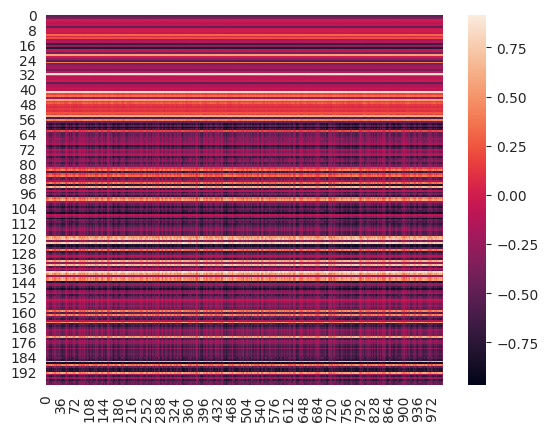

In [18]:
import seaborn as sns
sim = NetworkSimulator(best_nets_ddns[0])
random_inputs = np.random.uniform(0, 0.5, size=(1000,))

net_states = sim.get_network_data(random_inputs) # Note that first few samples will have transient dynamics

sns.heatmap(net_states)

In [19]:
print(net_states.shape)

(199, 1000)


# Sampling different networks

In [23]:
from populations import FlexiblePopulation
# Pick your hyperparameter set
generation = 20
individual = 12
esn_hyperparameters_evolution = esn_dict['parameters']
ddn_hyperparameters_evolution = ddn_dict['parameters']
esn_hyperparams = esn_hyperparameters_evolution[generation][individual]
ddn_hyperparams = esn_hyperparameters_evolution[generation][individual]

# update/resample the networks
example_esn = best_nets_esns[5]
example_ddn = best_nets_ddns[5]

specific_esn = example_esn.get_new_network_from_serialized(esn_hyperparams)
specific_ddn = example_esn.get_new_network_from_serialized(ddn_hyperparams)

Exception ignored in: <function PhotoImage.__del__ at 0x7f4db5748d30>
Traceback (most recent call last):
  File "/home/idlab237/ddn_public/DDN-public/venv/autograding/lib/python3.8/site-packages/PIL/ImageTk.py", line 118, in __del__
    name = self.__photo.name
AttributeError: 'PhotoImage' object has no attribute '_PhotoImage__photo'
Exception ignored in: <function PhotoImage.__del__ at 0x7f4db5748d30>
Traceback (most recent call last):
  File "/home/idlab237/ddn_public/DDN-public/venv/autograding/lib/python3.8/site-packages/PIL/ImageTk.py", line 118, in __del__
    name = self.__photo.name
AttributeError: 'PhotoImage' object has no attribute '_PhotoImage__photo'


<AxesSubplot: >

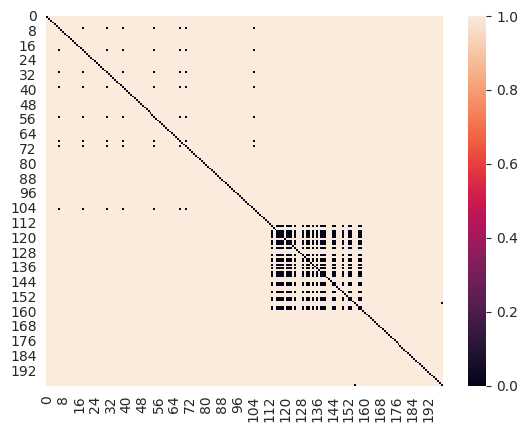

In [29]:
sns.heatmap(specific_ddn.D)